## Decision Tree Vs. Random Forest Classifier (Handwritten Digit Recognition)

### Imports

In [3]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading

In [4]:
def load_data_pd(file_path):
    # Load the file into a pandas DataFrame
    data = pd.read_csv(file_path, header=None)

    # The last column is the label, the rest are features
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values.astype(int)
    
    return features, labels

# Load training and testing data
train_features, train_labels = load_data_pd('C:\\Users\\tawse\\Codes\\ML projects\\Data\\optdigits.tes')
test_features, test_labels = load_data_pd('C:\\Users\\tawse\\Codes\\ML projects\\Data\\optdigits.tra')

### Visualize Digits

(1797, 64) (1797,)
(3823, 64) (3823,)


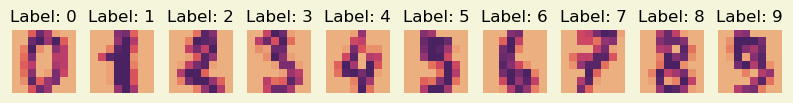

In [12]:
# Print the shapes of the datasets
print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

# Set up a single row of subplots for displaying 5 images
fig, axes = plt.subplots(1, 10, figsize=(8, 2), facecolor="beige")

# Loop through the first 5 samples
for i in range(10):
    axes[i].imshow(train_features[i].reshape(8, 8), cmap='flare')  
    axes[i].set_title(f"Label: {train_labels[i]}") 
    axes[i].axis("off") 

# Adjust layout and display all images on the same line
plt.tight_layout()
plt.show()


### Decsion Tree Implementation

In [13]:
def calculate_entropy(labels):
    classes, counts = np.unique(labels, return_counts=True)
    # print(classes)
    # print(counts)
    probabilities = counts / len(labels)
    # print(probabilities)
    return -np.sum(probabilities * np.log2(probabilities))

print(calculate_entropy(train_labels))  # Should print the entropy value

  

3.3217753538402386


### Entropy calculation and splitting

In [14]:
def split_dataset(features, labels, feature_idx, threshold):
    left_indices = features[:, feature_idx] <= threshold
    right_indices = features[:, feature_idx] > threshold
    return features[left_indices], labels[left_indices], features[right_indices], labels[right_indices]

def calculate_information_gain(parent_entropy, left_labels, right_labels):
    left_entropy = calculate_entropy(left_labels)
    right_entropy = calculate_entropy(right_labels)
    weight_left = len(left_labels) / (len(left_labels) + len(right_labels))
    weight_right = 1 - weight_left
    return parent_entropy - (weight_left * left_entropy + weight_right * right_entropy)

def find_best_split(features, labels, feature_subset=None):
    best_gain = -1
    best_split = None
    parent_entropy = calculate_entropy(labels)
    
    # Determine the features to evaluate
    feature_indices = feature_subset if feature_subset is not None else range(features.shape[1])
    
    for feature_idx in feature_indices:
        thresholds = np.unique(features[:, feature_idx])
        for threshold in thresholds:
            left_features, left_labels, right_features, right_labels = split_dataset(features, labels, feature_idx, threshold)
            if len(left_labels) == 0 or len(right_labels) == 0:
                continue
            gain = calculate_information_gain(parent_entropy, left_labels, right_labels)
            if gain > best_gain:
                best_gain = gain
                best_split = {
                    "feature_idx": feature_idx,
                    "threshold": threshold,
                    "gain": gain,
                    "left_indices": left_labels,
                    "right_indices": right_labels,
                }
    return best_split

### Build Decision Tree

In [15]:
def build_decision_tree(features, labels, depth=0, max_depth=None, max_features=None):
    # Base case: If all labels are the same, return a leaf node
    if len(np.unique(labels)) == 1:
        return {"label": labels[0]}
    
    # Base case: If no features left to split or max depth is reached
    if features.shape[0] == 0 or (max_depth is not None and depth >= max_depth):
        majority_label = np.bincount(labels).argmax()
        return {"label": majority_label}
    
    # Randomly select a subset of features for this split (Random Forest)
    if max_features:
        feature_subset = np.random.choice(features.shape[1], size=max_features, replace=False)
    else:
        feature_subset = None  # Use all features (Decision Tree behavior)
    
    # Find the best split
    best_split = find_best_split(features, labels, feature_subset)
    if best_split is None or best_split["gain"] <= 0:
        majority_label = np.bincount(labels).argmax()
        return {"label": majority_label}
    
    # Create the node
    feature_idx = best_split["feature_idx"]
    threshold = best_split["threshold"]
    
    left_features, left_labels, right_features, right_labels = split_dataset(
        features, labels, feature_idx, threshold
    )
    
    # Recursively build left and right subtrees
    left_subtree = build_decision_tree(left_features, left_labels, depth + 1, max_depth, max_features)
    right_subtree = build_decision_tree(right_features, right_labels, depth + 1, max_depth, max_features)
    
    return {
        "feature_idx": feature_idx,
        "threshold": threshold,
        "gain": best_split["gain"],
        "left": left_subtree,
        "right": right_subtree,
    }

### Visualise Decision Tree

In [16]:
# Build the tree with training data
def print_tree(tree, depth=0):
    """
    Recursively print the decision tree.

    Args:
        tree (dict): The decision tree dictionary structure.
        depth (int): Current depth in the tree for indentation.
    """
    indent = "  " * depth  # Indentation for better visualization
    
    # Check if the node is a leaf
    if "label" in tree:
        print(f"{indent}Leaf: Predict {tree['label']}")
    else:
        # Print decision node details
        print(f"{indent}Feature[{tree['feature_idx']}] <= {tree['threshold']}")
        print(f"{indent}  Gain: {tree['gain']:.4f}")
        print(f"{indent}Left:")
        print_tree(tree['left'], depth + 1)
        print(f"{indent}Right:")
        print_tree(tree['right'], depth + 1)

# Example usage:
decision_tree = build_decision_tree(train_features, train_labels, max_depth=10)

# Print the tree (for visualization purposes)
import pprint
pprint.pprint(decision_tree)

{'feature_idx': 42,
 'gain': 0.4620729303650686,
 'left': {'feature_idx': 26,
          'gain': 0.4375021302158588,
          'left': {'feature_idx': 43,
                   'gain': 0.6263602559825239,
                   'left': {'feature_idx': 30,
                            'gain': 0.5023600794923937,
                            'left': {'feature_idx': 19,
                                     'gain': 0.2894658599071154,
                                     'left': {'feature_idx': 29,
                                              'gain': 0.21078727680694564,
                                              'left': {'feature_idx': 28,
                                                       'gain': 0.08940020181768857,
                                                       'left': {'feature_idx': 1,
                                                                'gain': 0.9182958340544896,
                                                                'left': {'label': 2},
                 

### Predict Using Decision Tree

In [17]:
def predict(tree, sample):
    # If the node is a leaf, return its label
    if "label" in tree:
        return tree["label"]
    
    # Decide the path based on the feature and threshold
    feature_idx = tree["feature_idx"]
    threshold = tree["threshold"]
    
    if sample[feature_idx] <= threshold:
        return predict(tree["left"], sample)
    else:
        return predict(tree["right"], sample)

# Predict on a single sample
sample = test_features[7]
print(f"Predicted: {predict(decision_tree, sample)}, Actual: {test_labels[7]}")

# Predict on all test samples
predictions = [predict(decision_tree, sample) for sample in test_features]

Predicted: 5, Actual: 5


### Evaluate the Decsion Tree

Accuracy: 0.8271

Class-wise Metrics:
Class 0: Precision=0.9119, Recall=0.9362, F1-Score=0.9239
Class 1: Precision=0.8743, Recall=0.8046, F1-Score=0.8380
Class 2: Precision=0.7716, Recall=0.8447, F1-Score=0.8065
Class 3: Precision=0.7596, Recall=0.7635, F1-Score=0.7615
Class 4: Precision=0.8946, Recall=0.7674, F1-Score=0.8261
Class 5: Precision=0.8203, Recall=0.8378, F1-Score=0.8289
Class 6: Precision=0.8880, Recall=0.9257, F1-Score=0.9065
Class 7: Precision=0.8782, Recall=0.8760, F1-Score=0.8771
Class 8: Precision=0.7368, Recall=0.7368, F1-Score=0.7368
Class 9: Precision=0.7531, Recall=0.7827, F1-Score=0.7677


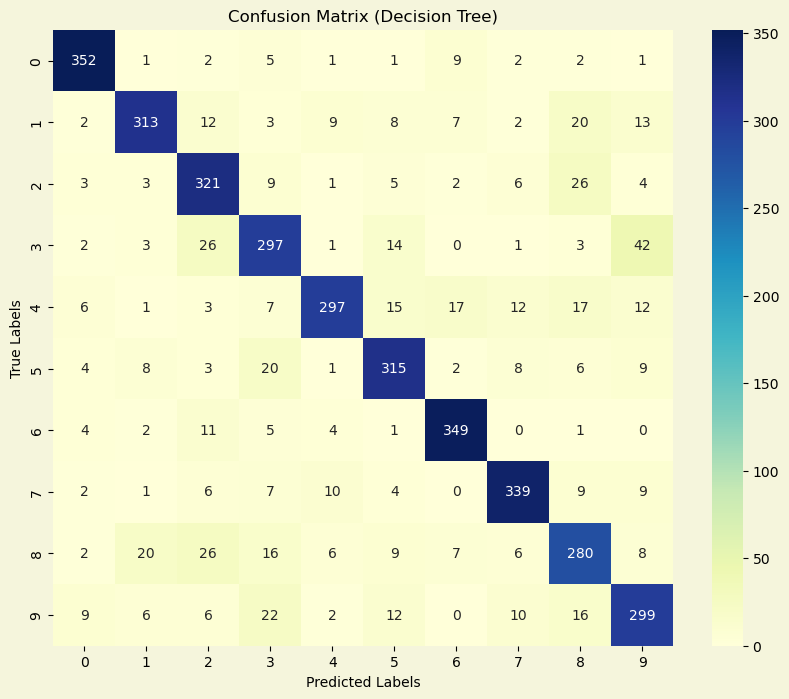

In [18]:
# Calculate accuracy
def calculate_accuracy(true_labels, predictions):
    correct = np.sum(true_labels == predictions)
    total = len(true_labels)
    return correct / total

# Build confusion matrix
def build_confusion_matrix(true_labels, predictions, n_classes):
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for true, pred in zip(true_labels, predictions):
        conf_matrix[true, pred] += 1
    return conf_matrix

# Calculate precision, recall, and F1-score for each class
def calculate_metrics(conf_matrix):
    
    n_classes = conf_matrix.shape[0]
    metrics = {"precision": [], "recall": [], "f1_score": []}

    for i in range(n_classes):
        tp = conf_matrix[i, i]  # True positives
        fp = np.sum(conf_matrix[:, i]) - tp  # False positives
        fn = np.sum(conf_matrix[i, :]) - tp  # False negatives
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1_score"].append(f1_score)
    
    return metrics

# Evaluate predictions
accuracy = calculate_accuracy(test_labels, predictions)
conf_matrix = build_confusion_matrix(test_labels, predictions, n_classes=10)
metrics = calculate_metrics(conf_matrix)

# Print results
print(f"Accuracy: {accuracy:.4f}")
# print("\nConfusion Matrix:")
# print(conf_matrix)

print("\nClass-wise Metrics:")
for i in range(10):
    print(f"Class {i}: Precision={metrics['precision'][i]:.4f}, Recall={metrics['recall'][i]:.4f}, F1-Score={metrics['f1_score'][i]:.4f}")

# Optionally plot the confusion matrix
plt.figure(figsize=(10, 8), facecolor="beige")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Random Forest Implementation

### Bootstraping Samples

In [19]:
def bootstrap_sample(features, labels):
    n_samples = features.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return features[indices], labels[indices]

### Build Random Forest

In [21]:
def build_random_forest(features, labels, n_trees, max_depth=None, max_features=None):
    forest = []
    for _ in range(n_trees):
        # Bootstrap sampling
        boot_features, boot_labels = bootstrap_sample(features, labels)
        
        # Build a decision tree
        tree = build_decision_tree(boot_features, boot_labels, max_depth=max_depth, max_features=max_features)
        forest.append(tree)
    return forest

### Predict Using Random Forest

In [22]:
def random_forest_predict(forest, sample):
    tree_predictions = [predict(tree, sample) for tree in forest]
    return np.bincount(tree_predictions).argmax()

def random_forest_predict_all(forest, features):
    return [random_forest_predict(forest, sample) for sample in features]

from math import sqrt

# Train Random Forest
n_trees = 10
max_features = int(sqrt(train_features.shape[1]))  # sqrt(total_features)
random_forest = build_random_forest(train_features, train_labels, n_trees, max_depth=10, max_features=max_features)

# Predict on test data
rf_predictions = random_forest_predict_all(random_forest, test_features)

### Evaluating the Random Forest

Accuracy: 0.9239

Class-wise Metrics:
Class 0: Precision=0.9841, Recall=0.9894, F1-Score=0.9867
Class 1: Precision=0.9215, Recall=0.9357, F1-Score=0.9286
Class 2: Precision=0.9578, Recall=0.9553, F1-Score=0.9565
Class 3: Precision=0.9051, Recall=0.9075, F1-Score=0.9063
Class 4: Precision=0.9803, Recall=0.9018, F1-Score=0.9394
Class 5: Precision=0.9739, Recall=0.8936, F1-Score=0.9320
Class 6: Precision=0.9536, Recall=0.9814, F1-Score=0.9673
Class 7: Precision=0.9035, Recall=0.9922, F1-Score=0.9458
Class 8: Precision=0.8705, Recall=0.8316, F1-Score=0.8506
Class 9: Precision=0.8045, Recall=0.8508, F1-Score=0.8270


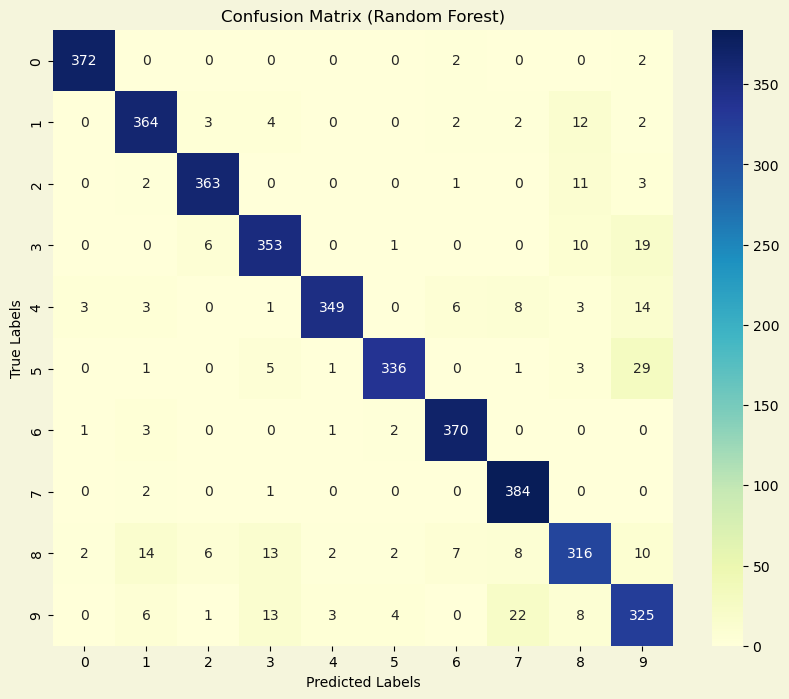

In [23]:
# Step 1: Predict on the test data using the random forest
rf_predictions = random_forest_predict_all(random_forest, test_features)

# Step 2: Calculate Accuracy
accuracy = calculate_accuracy(test_labels, rf_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Step 3: Build the Confusion Matrix
conf_matrix = build_confusion_matrix(test_labels, rf_predictions, n_classes=10)
# print("\nConfusion Matrix:")
# print(conf_matrix)

# Step 4: Calculate precision, recall, and F1-score for each class
metrics = calculate_metrics(conf_matrix)

# Step 5: Print the metrics for each class
print("\nClass-wise Metrics:")
for i in range(10):  # For each class (0 to 9)
    print(f"Class {i}: Precision={metrics['precision'][i]:.4f}, Recall={metrics['recall'][i]:.4f}, F1-Score={metrics['f1_score'][i]:.4f}")

# Optionally: Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8), facecolor="beige")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()